# User example for DE class

In [1]:
import random
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

In [2]:
import random
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

class EvoTreeOptimization(object):
    '''This class stores evolutionary optimization algorithms to trees based models'''
    
     # inicilaization function
    def __init__(self, cost_func, bounds, popsize=10, mutate=0.5, recombination=0.7, maxiter=2000):
        self.cost_func=cost_func
        self.bounds=bounds
        self.popsize=popsize
        self.mutate=mutate
        self.recombination=recombination
        self.maxiter=maxiter 
        self.bestInd = []
        self.meanpop = []
        self.best = []
        self.globvar = 0 # variable created to tune the output predicted value

    def ensure_bounds(self,vec, bounds):
        vec_new = []
        # cycle through each variable in vector
        for i in range(len(vec)):

            # variable exceedes the minimum boundary
            if vec[i] < bounds[i][0]:
                vec_new.append(bounds[i][0])

            # variable exceedes the maximum boundary
            if vec[i] > bounds[i][1]:
                vec_new.append(bounds[i][1])

            # the variable is fine
            if bounds[i][0] <= vec[i] <= bounds[i][1]:
                vec_new.append(vec[i])

        return vec_new
    
    def plotEvolution(self):
        plt.plot(trainX.meanpop)
        plt.plot(trainX.bestInd)
        plt.ylabel('cost function' + str(cost_func) )
        plt.ylabel('epochs')
        plt.show()

    
    def earlyFunc(self,preds, train_data):
        labels = train_data.get_label()
        return 'error',  self.cost_func(labels,np.round(preds-self.globvar)), True

    def lgbm_tra(self,x,X,y):

        # seleciona os parametros para treinamento
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'xentropy',#'binary',
            'num_leaves': int(x[1]),      # 31
            'learning_rate': x[2],   #0.01,
            'feature_fraction': x[3],#0.9,
            'bagging_fraction': x[4],#0.8,
            'bagging_freq': 1,
            'max_depth': int(x[5]),        #-1,
            'min_data_in_leaf': int(x[6]), #20,
            'lambda_l2': x[7],        # 0,
            'is_unbalance' : True,
            'max_bin' : int(x[9]),
            'verbose': -1
        }
        num_k = 5
        acc = 0
        # treina a arvore
        kf = KFold(n_splits=num_k,random_state=21)

        self.globvar = x[8]

        for train_index, test_index in kf.split(X):
           #print("TRAIN:", train_index, "TEST:", test_index)
           X_train, X_test = X[train_index], X[test_index]
           y_train, y_test = y[train_index], y[test_index]

           lgb_train = lgb.Dataset(X_train, y_train)


           lgb_test = lgb.Dataset(X_test, y_test)
           #gbm = lgb.train(params, lgb_train, num_boost_round=int(x[0])  ) #x[0]

           gbm = lgb.train(params, lgb_train, num_boost_round=int(x[0]),valid_sets = [lgb_test],early_stopping_rounds=30,feval = self.earlyFunc, verbose_eval= 0)     #x[0]

           y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
           acc += f1_score(y_test,np.round(y_pred-x[8]) ) # F1 score

        return (acc/num_k)



    def run(self,x_train,y_train):
        # --- INITIALIZE A POPULATION (step #1) ----------------+

        population = []
        for i in range(0, self.popsize):
            indv = []
            for j in range(len(self.bounds)):
                indv.append(random.uniform(self.bounds[j][0], self.bounds[j][1]))
            population.append(indv)

        print('First gen ...')
        scorePop = np.zeros(self.popsize)
        for num, ind in enumerate(population):
            scorePop[num] = self.lgbm_tra(ind, x_train, y_train)
            print(scorePop[num])

        # --- SOLVE --------------------------------------------+

        # cycle through each generation (step #2)
        for i in range(1, self.maxiter + 1):
            print('GENERATION:', i)

            gen_scores = []  # score keeping

            # cycle through each individual in the population
            for j in range(0, self.popsize):

                # --- MUTATION (step #3.A) ---------------------+

                # select three random vector index positions [0, popsize), not including current vector (j)
                candidates = np.arange(0, self.popsize)
                candidates = np.delete(candidates, j)

                random_index = np.random.permutation(candidates)

                x_1 = population[random_index[0]]
                x_2 = population[random_index[1]]
                x_3 = population[random_index[2]]
                x_t = population[j]  # target individual

                # subtract x3 from x2, and create a new vector (x_diff)
                x_diff = [x_2_i - x_3_i for x_2_i, x_3_i in zip(x_2, x_3)]

                # multiply x_diff by the mutation factor (F) and add to x_1
                v_donor = [x_1_i + self.mutate * x_diff_i for x_1_i, x_diff_i in zip(x_1, x_diff)]
                v_donor = self.ensure_bounds(v_donor, self.bounds)

                # --- RECOMBINATION (step #3.B) ----------------+

                v_trial = []
                for k in range(len(x_t)):
                    crossover = random.random()
                    if crossover <= self.recombination:
                        v_trial.append(v_donor[k])

                    else:
                        v_trial.append(x_t[k])

                # --- GREEDY SELECTION (step #3.C) -------------+

                score_trial = self.lgbm_tra(v_trial,x_train,y_train)
                score_target = scorePop[j]

                if score_trial > score_target:
                    population[j] = v_trial
                    scorePop[j] = score_trial
                    #print(score_target, '   <', score_trial, v_trial)

                else:
                    pass
                    #print(score_target,'   >', score_target, x_t)


            # --- SCORE KEEPING --------------------------------+
            gen_avg = np.mean(scorePop)  # current generation avg. fitness
            gen_best = max(scorePop)  # fitness of best individual
            gen_sol = population[np.argmax(scorePop)]  # solution of best individual

            print('      > GENERATION AVERAGE:', gen_avg)
            print('      > GENERATION BEST:', gen_best)
            print('         > BEST SOLUTION:', gen_sol, '\n')
            
            self.bestInd.append(gen_best)
            self.meanpop.append(gen_avg)
            self.best = gen_sol

        return gen_sol

In [3]:
data = load_breast_cancer()
x = data.data
y = data.target

In [4]:
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score 

In [5]:
cost_func = f1_score  # Cost function
cost_func = accuracy_score
bounds = [(200, 1000),(15,50), (0.001,0.1 ), (0.5, 1),(0.7, 1), (6, 30),(10, 30),(0,20),(-0.4,0.4),(32,128)]  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]

In [6]:
trainX = EvoTreeOptimization(cost_func,bounds)

In [ ]:
trainX.run(x,y)

First gen ...


/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.7625524765154669
0.7851626460069923
0.9580253104256228
0.9505360708273445
0.9582908955489711
0.3682219419924338
0.9392188939915114
0.7625524765154669
0.9499684543665191
0.9529119909570045
GENERATION: 1
      > GENERATION AVERAGE: 0.9593647551403611
      > GENERATION BEST: 0.971217795960053
         > BEST SOLUTION: [422.72487579914946, 50, 0.1, 0.9195508360070478, 0.9778804606325554, 16.01394424740031, 10, 10.456817342194835, 0.013937022990445413, 78.80340345380748] 

GENERATION: 2
      > GENERATION AVERAGE: 0.9628859251371636
      > GENERATION BEST: 0.971217795960053
         > BEST SOLUTION: [422.72487579914946, 50, 0.1, 0.9195508360070478, 0.9778804606325554, 16.01394424740031, 10, 10.456817342194835, 0.013937022990445413, 78.80340345380748] 

GENERATION: 3
      > GENERATION AVERAGE: 0.9676643384221426
      > GENERATION BEST: 0.9770022218765624
         > BEST SOLUTION: [400.0653344757476, 20.304453077102366, 0.06718719238447732, 0.8753564887316123, 0.8922377391925181, 9.4786

      > GENERATION AVERAGE: 0.9769081751810506
      > GENERATION BEST: 0.9788447158832747
         > BEST SOLUTION: [435.00734441360777, 43.35164778101719, 0.1, 0.5330237529951689, 0.8618034941898483, 13.811334190680604, 14.5583255282634, 3.0336394014875485, 0.11429056055117903, 121.33304223569608] 

GENERATION: 27
      > GENERATION AVERAGE: 0.9771185629205131
      > GENERATION BEST: 0.9788447158832747
         > BEST SOLUTION: [435.00734441360777, 43.35164778101719, 0.1, 0.5330237529951689, 0.8618034941898483, 13.811334190680604, 14.5583255282634, 3.0336394014875485, 0.11429056055117903, 121.33304223569608] 

GENERATION: 28
      > GENERATION AVERAGE: 0.9771185629205131
      > GENERATION BEST: 0.9788447158832747
         > BEST SOLUTION: [435.00734441360777, 43.35164778101719, 0.1, 0.5330237529951689, 0.8618034941898483, 13.811334190680604, 14.5583255282634, 3.0336394014875485, 0.11429056055117903, 121.33304223569608] 

GENERATION: 29
      > GENERATION AVERAGE: 0.9772500443395261

      > GENERATION AVERAGE: 0.9786991388724584
      > GENERATION BEST: 0.9808037131497482
         > BEST SOLUTION: [559.3280662595533, 15, 0.1, 0.5, 0.8450306046055032, 6, 28.42189337016899, 0, 0.16804020689791233, 65.21544266117259] 

GENERATION: 59
      > GENERATION AVERAGE: 0.9786991388724584
      > GENERATION BEST: 0.9808037131497482
         > BEST SOLUTION: [559.3280662595533, 15, 0.1, 0.5, 0.8450306046055032, 6, 28.42189337016899, 0, 0.16804020689791233, 65.21544266117259] 

GENERATION: 60
      > GENERATION AVERAGE: 0.9786991388724584
      > GENERATION BEST: 0.9808037131497482
         > BEST SOLUTION: [559.3280662595533, 15, 0.1, 0.5, 0.8450306046055032, 6, 28.42189337016899, 0, 0.16804020689791233, 65.21544266117259] 

GENERATION: 61
      > GENERATION AVERAGE: 0.9786991388724584
      > GENERATION BEST: 0.9808037131497482
         > BEST SOLUTION: [559.3280662595533, 15, 0.1, 0.5, 0.8450306046055032, 6, 28.42189337016899, 0, 0.16804020689791233, 65.21544266117259] 

GEN

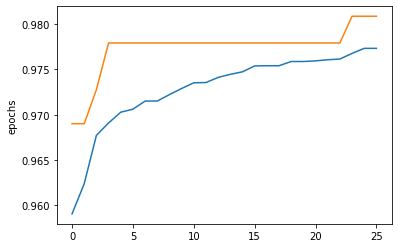

In [117]:
trainX.plotEvolution()



In [104]:
trainX.best

[903.7959525504085,
 50,
 0.09556065107657785,
 0.5423759479971532,
 0.7243185537644876,
 6,
 10,
 4.969992342499635,
 -0.01574093973387005,
 36.73700789749618]

In [116]:
str(cost_func)

'<function accuracy_score at 0x7f3595a537a0>'